# Bivariate Observations

Insurers are typically exposed to more than one type of risk, and it can be beneficial for them to consider the joint risk profile for related products.

This example considers a joint model for the frequency of claims reported for two nonlife insurance portfolios.
The claim counts are Poisson distributed  with respective intensity $\Lambda w_1$ and $\Lambda w_2$ where $\Lambda$ is some non-negative random variable.

The frequency data $(n_1,m_1),\ldots, (n_t,m_t)$ is i.i.d. according to a bivariate counting distribution with joint p.m.f. given by

$$
	p_{N,M}(n,m) = \int\frac{\mathrm{e}^{-\lambda w_1}(\lambda w_1)^n}{n!}\frac{\mathrm{e}^{-\lambda w_2}(\lambda w_2)^m}{m!} \mathrm{d} \mathbb{P}_\Lambda(\lambda), \quad n,m = 0, 1, \dots.
$$

The severities associated to a given time period $s=1,\ldots, t$ form two mutually independent, \iid sequences of exponentially distributed random variables,

$$
	u_{s,1},\ldots, u_{s,n_s} \overset{\mathrm{i.i.d.}}{\sim} \mathsf{Exp}(m_1 = 10) \quad \text{and} \quad
	v_{s,1},\ldots, v_{s,m_s} \overset{\mathrm{i.i.d.}}{\sim} \mathsf{Exp}(m_2 = 40).
$$

The model encapsulate the link between the frequencies of two insurance portfolios while accommodating for the well known overdispersed nature of the claim count data.

## Generating some synthetic data to fit

We start by importing some necessary packages.

In [1]:
%config InlineBackend.figure_format = 'retina'
import approxbayescomp as abc
import numpy as np
import numpy.random as rnd

We will fit simulated data, so that we know the true value of the parameters for the data-generating process.
We let $\Lambda$ be a lognormal random variable $\mathsf{Lognormal}(\sigma=0.2)$ (the mean log parameter is set to $0$) as it is consistent with the use of a generalized linear model equipped with a log link function to estimate the Poisson intensity given a set of covariates.
The marginal components of the claim frequency distribution are set to $w_1 = 15$ and $w_2 = 5$.
Finally, we observe $T = 250$ i.i.d. bivariate observations.

In [2]:
# Create a pseudorandom number generator
rg = rnd.default_rng(1234)

# Parameters of the true model
freq = "bivariate poisson"
sev = "exponential"
σ = 0.2
w1 = 15
w2 = 5
m1 = 10
m2 = 70
trueTheta = (σ, w1, w2, m1, m2)

# Setting the time horizon
T = 250

# Simulating the claim data
claimsData = abc.simulate_claim_data(rg, T, freq, sev, trueTheta)

# Simulating the observed data
psi = abc.Psi("sum")

xData1 = abc.compute_psi(claimsData[0][0], claimsData[0][1], psi)
xData2 = abc.compute_psi(claimsData[1][0], claimsData[1][1], psi)

xData = np.vstack([xData1, xData2]).T

We can see if any of this observed data contains pesky zeros:

In [3]:
np.sum(xData == 0)

4

Also, as we have bivariate data, we will use a special distance function which expects to receive a matrix with two columns:

In [4]:
xData.shape

(250, 2)

## Use ABC to fit the data

With this data, we create objects to represent the data-generating process (the model) and the prior distribution.
The priors are set as

$$\sigma \sim \mathsf{Unif}(0, 2), \quad w_1 \sim \mathsf{Unif}(0, 50), \quad w_2 \sim \mathsf{Unif}(0, 50)$$
$$m_1 \sim \mathsf{Unif}(0, 100), \quad \text{ and } \quad m_2 \sim \mathsf{Unif}(0, 100).$$

In [5]:
model = abc.Model(freq, sev, psi)
prior = abc.IndependentUniformPrior([(0, 2), (0, 50), (0, 50), (0, 100), (0, 100)])

Finally, we call the main `smc` method to fit the observed `xData`.

### Ignoring the zeros

In [6]:
numIters = 10
popSize = 250
%time fit = abc.smc(numIters, popSize, xData, model, prior, sumstats=abc.wass_2Ddist_ss, distance=abc.wass_2Ddist, numProcs=40, seed=1)

CPU times: user 1.28 s, sys: 812 ms, total: 2.09 s
Wall time: 36.7 s


These particles all generated fake data within the following distance to the observed data:

In [7]:
np.max(fit.dists)

54.01354927175102

Plotting the fitted ABC posterior:

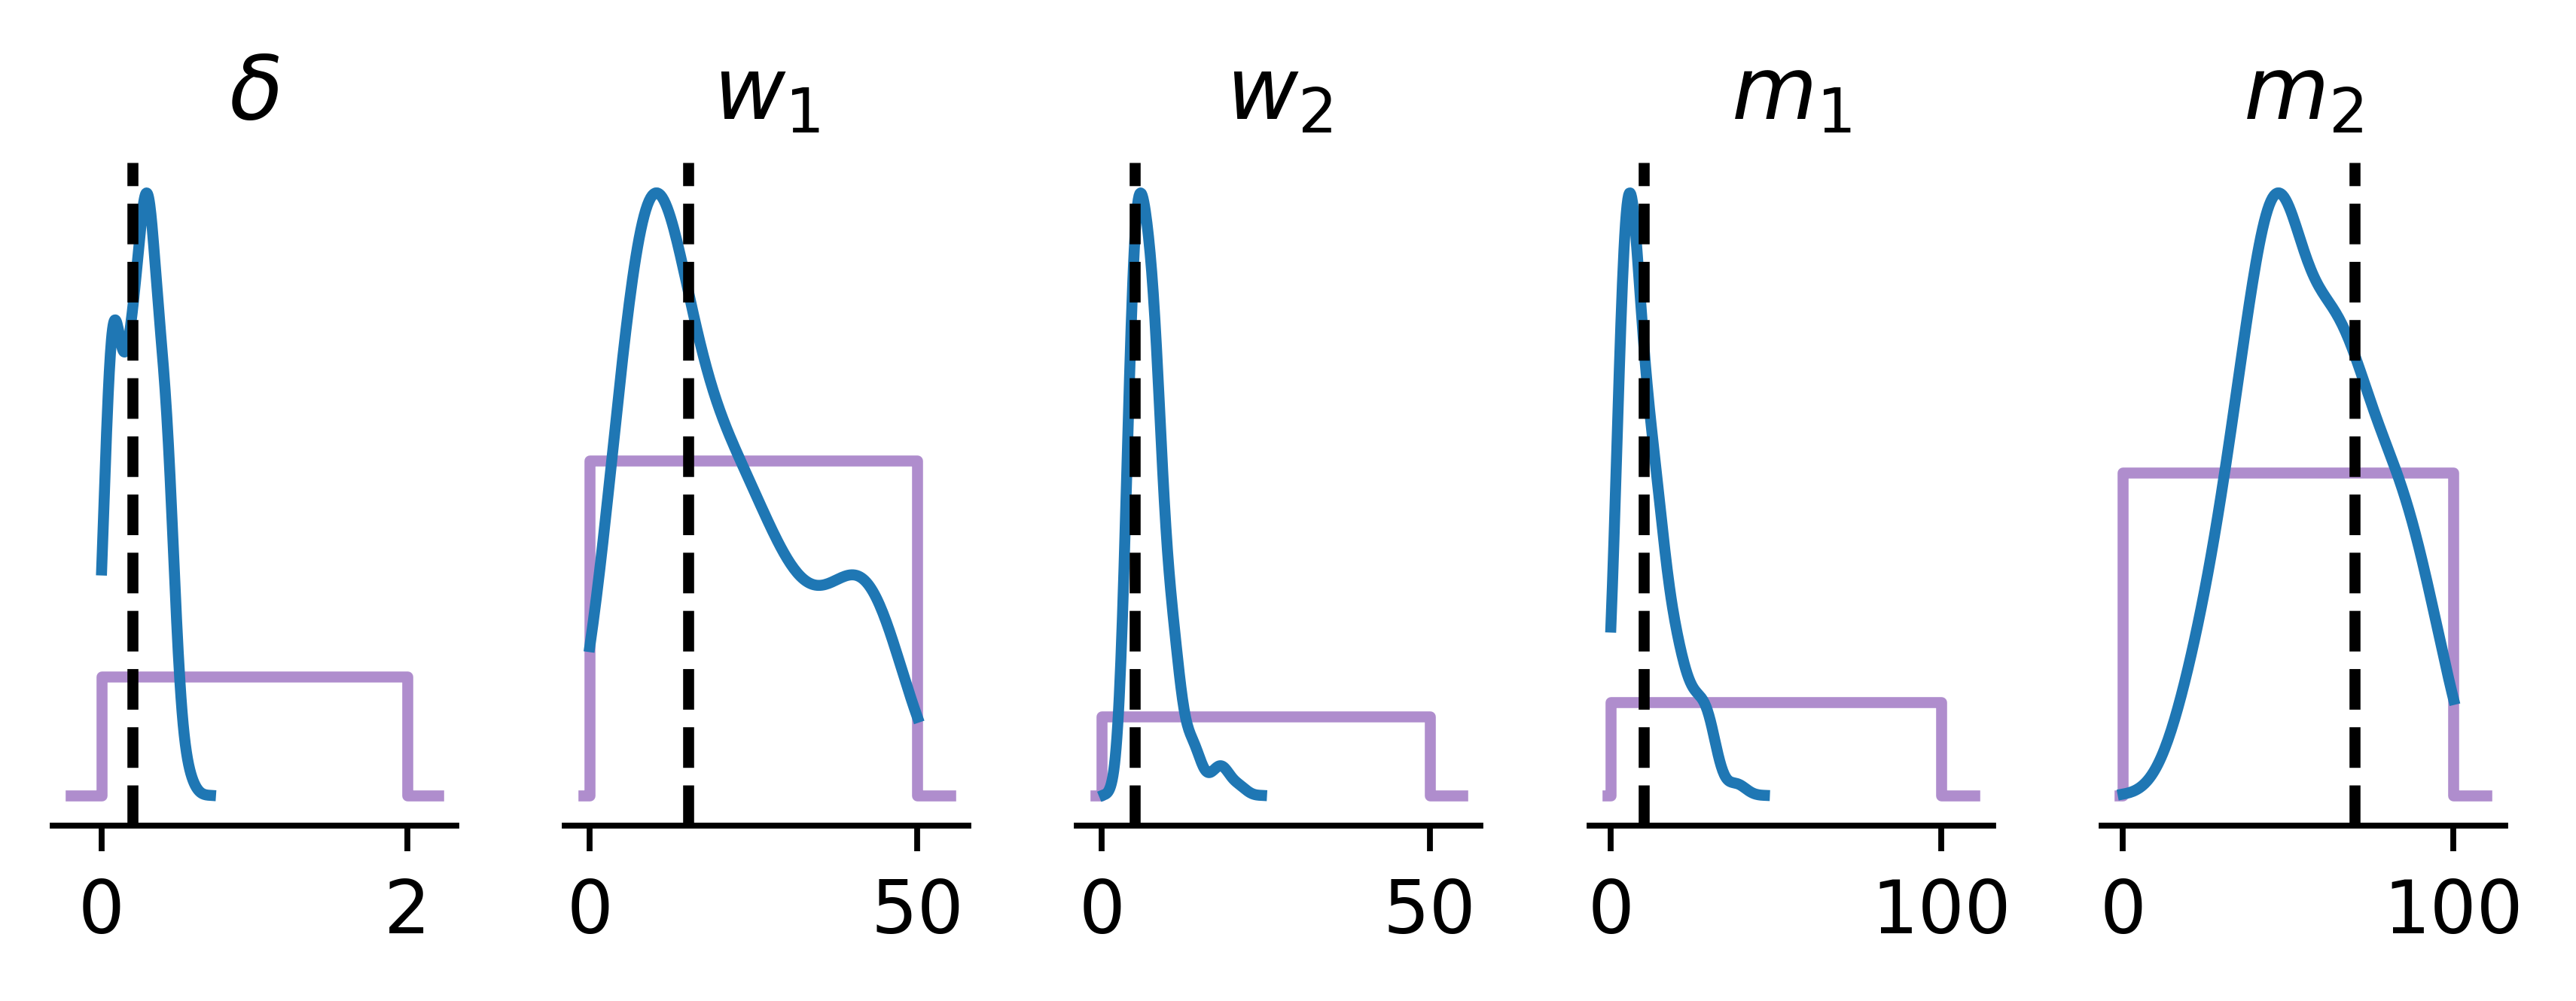

In [8]:
abc.plot_posteriors(
    fit,
    prior,
    subtitles=["$\\delta$", "$w_1$", "$w_2$", "$m_1$", "$m_2$"],
    refLines=trueTheta,
    removeYAxis=True,
)

### Matching the zeros

Trying a second time with the `matchZeros` flag on:

In [9]:
numIters = 10
popSize = 250
%time fitMatchZeros = abc.smc(numIters, popSize, xData, model, prior, matchZeros=True, sumstats=abc.wass_2Ddist_ss, distance=abc.wass_2Ddist, numProcs=40, seed=1)

CPU times: user 1.37 s, sys: 137 ms, total: 1.51 s
Wall time: 45.1 s


These particles all generated fake data within the following distance to the observed data:

In [10]:
np.max(fitMatchZeros.dists)

31.0354823458702

Plotting the fitted ABC posterior:

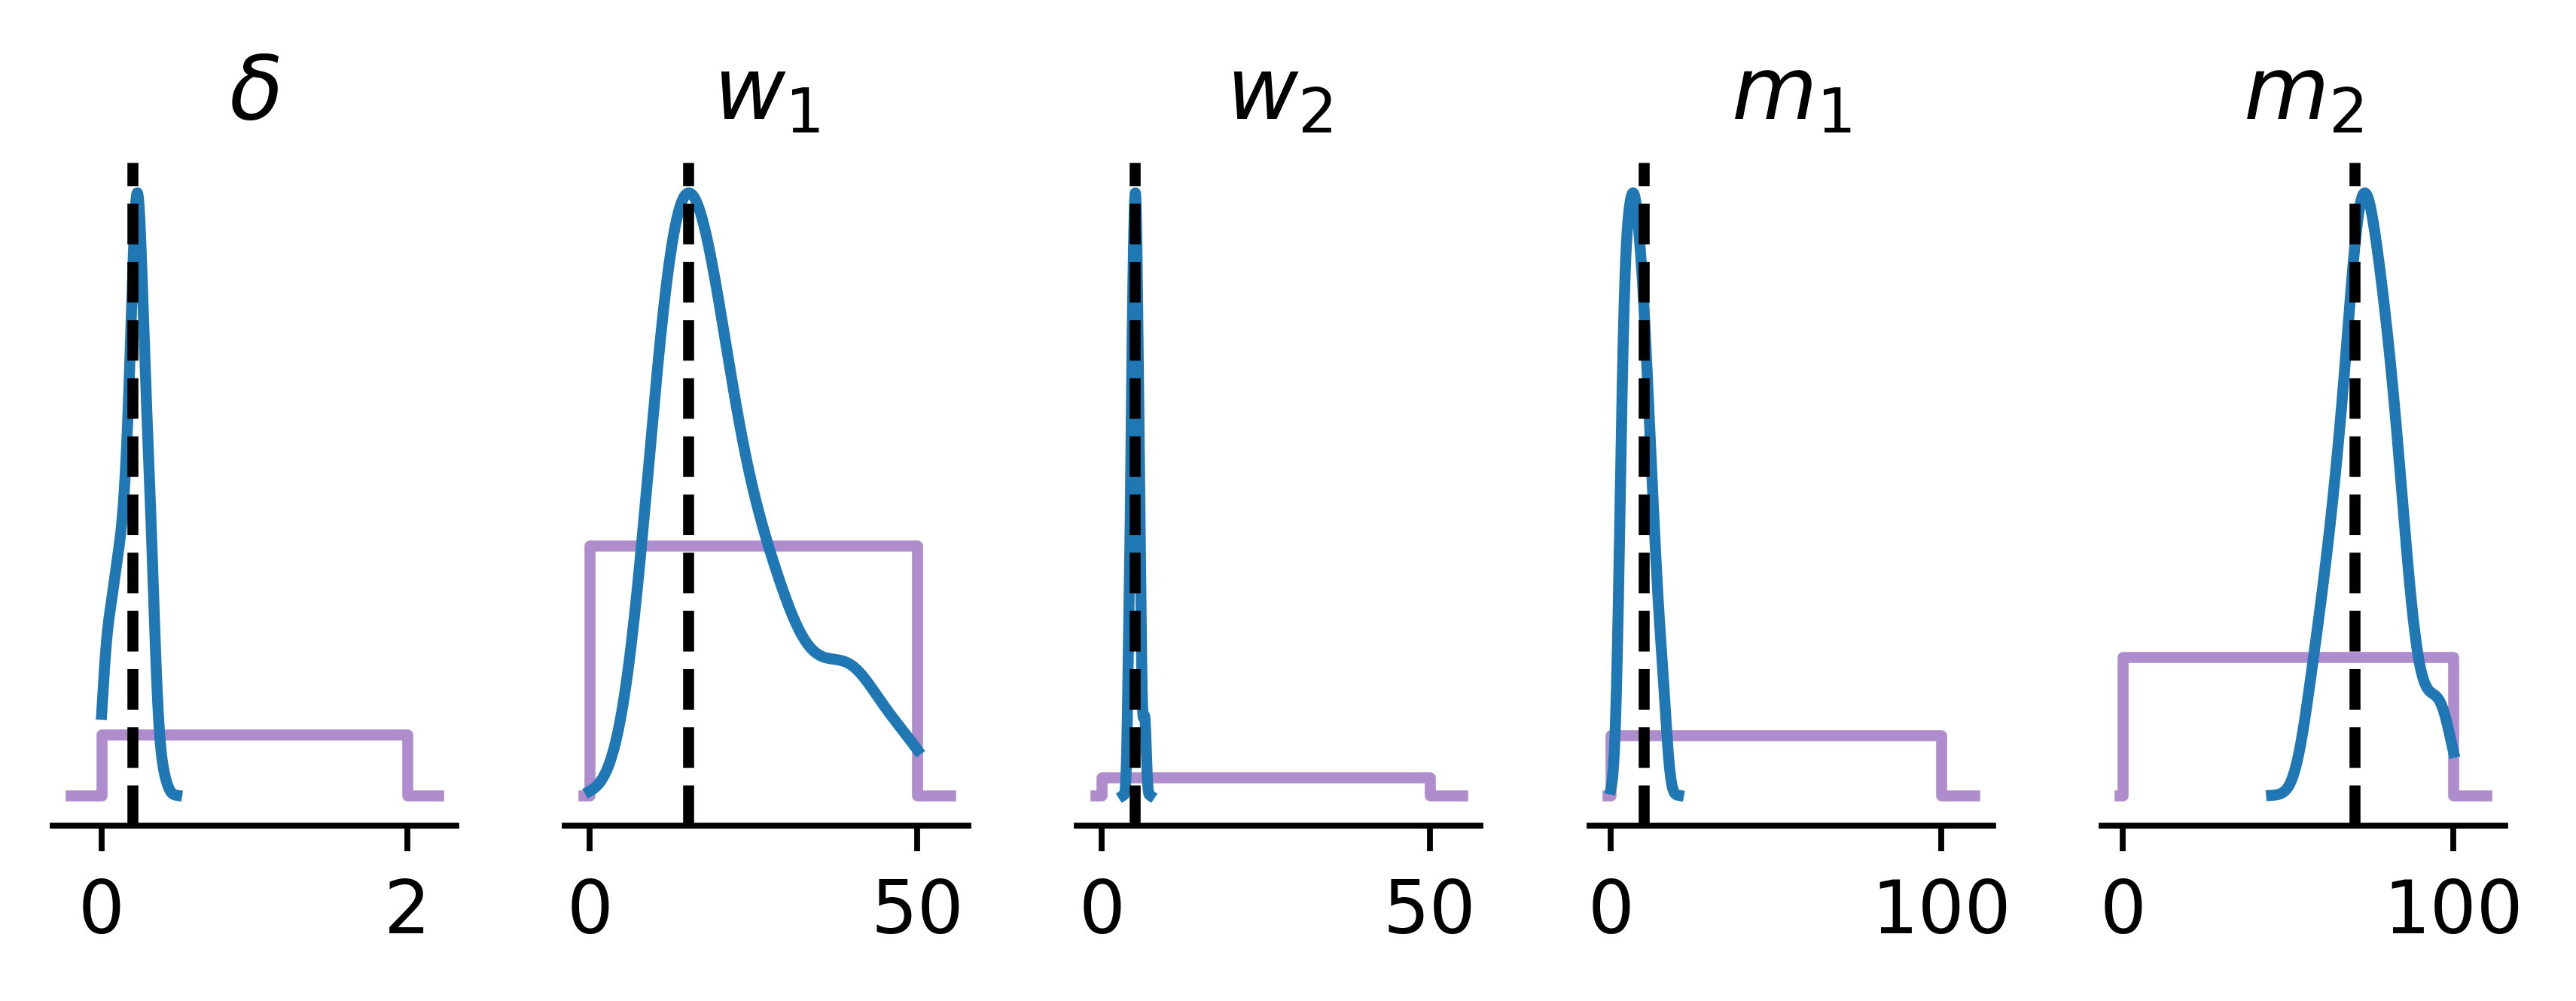

In [11]:
abc.plot_posteriors(
    fitMatchZeros,
    prior,
    subtitles=["$\\delta$", "$w_1$", "$w_2$", "$m_1$", "$m_2$"],
    refLines=trueTheta,
    removeYAxis=True,
)

In this case, the `matchZeros` is much more accurate than the previous fit.